# Tweets sentiment analysis

### Importing the libraries

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import BertModel, BertTokenizer

import numpy as np

#MANAGEMENT PURPOSES ONLY-
from tqdm.notebook import tqdm
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
pre_trained_model = 'bert-base-cased'

Set seed to ensure reproducibility

In [4]:
SEED = 32
np.random.seed(SEED)
torch.manual_seed(SEED)

Set CUDA if available

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.version.cuda) 

cuda
11.3


### Load processed dataset

In [6]:
X = np.load('./data/X.npy', allow_pickle=True)
y = np.load('./data/y.npy')

X_NOLABEL = np.load('./data/X_TEST_NO_LABEL.npy', allow_pickle=True)

In [7]:
X.shape

(420, 200)

In [8]:
X[0][0]

"#USER# I'll DM you my address."

In [9]:
X_NOLABEL[0][0]

'Thursday games. Yet another triumph for #USER# #HASHTAG# #HASHTAG#'

In [10]:
y[0]

1

### Define a tokenizer

In [11]:
tokenizer = BertTokenizer.from_pretrained(pre_trained_model, do_lower_case=False)

In [12]:
def get_encoding(text, max_length, truncation=True):
    return tokenizer.encode_plus(
            text, 
            max_length=max_length, 
            add_special_tokens=True,
            return_token_type_ids=False, 
            padding='max_length', 
            truncation=truncation,
            return_attention_mask=True, 
            return_tensors='pt')

Lets see an example of tokenizing a tweet:

In [13]:
example_text = X[0][0]
encoding = get_encoding(example_text, 32, truncation=False)

In [14]:
example_text

"#USER# I'll DM you my address."

In [15]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', '#', 'US', '##ER', '#', 'I', "'", 'll', 'D', '##M', 'you', 'my', 'address', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
# Length of the heading, body and space separator
token_lengths = {}
max_value = -1
for user in tqdm(range(X.shape[0]), desc='Profiles'):
    for tweet in range(X.shape[1]):
        text = X[user][tweet]
        l = len(tokenizer.encode(text, max_length=280, truncation=True))
        if l not in token_lengths:
            token_lengths[l] = 0
        token_lengths[l] += 1
        max_value = max(max_value, token_lengths[l])

In [ ]:
# Normalize the counts
for key in token_lengths:
    token_lengths[key] = token_lengths[key] / max_value

In [ ]:
import matplotlib.pyplot as plt
plot_threshold = 0.01
plt.bar(list(token_lengths.keys()), token_lengths.values(), color='b')
plt.xlim([min([key for key in token_lengths.keys() if token_lengths[key] > plot_threshold]), max([key for key in token_lengths.keys() if token_lengths[key] > plot_threshold])])
plt.show()

In [16]:
MAX_TOKEN_LENGTH = 100

### Process tweets into matrices

In [17]:
bert = BertModel.from_pretrained(pre_trained_model)
bert = bert.to(device)
bert = bert.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
class TweetDataset(Dataset):

    def __init__(self, text):
        self.text = text

    def __len__(self):
        return 1
    
    def __getitem__(self, i):

        encoding = get_encoding(self.text, MAX_TOKEN_LENGTH, truncation=True)
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [19]:
def encode_tweet(text):
    output = None
    with torch.no_grad():
        dl = DataLoader(TweetDataset(text), batch_size=1, shuffle=False)
        encoding = next(iter(dl))
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        output = bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"]
        output = output[0].to('cpu').numpy()
    return output
    

In [20]:
def encode_profile(profile):
    encoded_tweets = []
    for tweet in profile:
        encoded_tweets.append(encode_tweet(tweet))

    encoded_tweets = np.array(encoded_tweets, dtype=np.float64)
    return encoded_tweets

In [21]:
encoded_profiles_nolabel = {}
for i in tqdm(range(len(X_NOLABEL)), desc='Encoding Profiles'):
    encoded_profiles_nolabel[i] = encode_profile(X_NOLABEL[i])


Encoding Profiles:   0%|          | 0/180 [00:00<?, ?it/s]

In [22]:
len(encoded_profiles_nolabel)

180

In [23]:
encoded_profiles_nolabel[0].shape

(200, 768)

In [24]:
output_filepath = os.path.join('data', 'profile_matrices_nolabel')

In [25]:
for i in tqdm(range(len(X_NOLABEL)), desc='Saving Profiles'):
    np.save(os.path.join(output_filepath, str(i)), encoded_profiles_nolabel[i])


Saving Profiles:   0%|          | 0/180 [00:00<?, ?it/s]

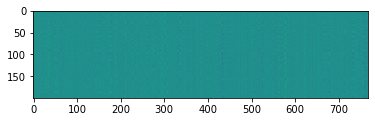

In [27]:
import matplotlib.pyplot as plt

plt.imshow(encoded_profiles_nolabel[0]-encoded_profiles_nolabel[8])

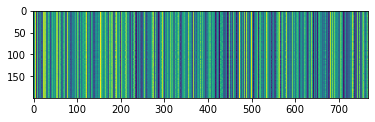

In [28]:
plt.imshow(encoded_profiles_nolabel[80])